# Hyperspectral Image autoencoder

1. Import dependencies

In [1]:
import random

import numpy as np
import torch

from torch import nn
from torch.utils import data

from src.util.torch import resolve_torch_device
from src.model.autoencoder import (
    SpatialAutoEncoder,
)
from src.trainer.autoencoder_trainer import AutoEncoderTrainer
from src.visualization.plot import plot_epoch_generic_comparison, plot_segmentation_comparison, plot_numbers_distribution
from sklearn.model_selection import train_test_split
from src.util.hsi import train_test_band_patch_split, extract_patches, PreProcessType, preprocess_hsi
from src.trainer.base_trainer import AdamOptimizedModule
from src.data.indian_pines import load_indian_pines

2. Prepare env

In [2]:
batch_size = 64
patch_size = 9
exampes_per_class = []

embedding_size = 17
epochs = 300
learning_rate = 1e-3
pre_process_type = PreProcessType.STANDARTIZATION

In [3]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

3. Load dataset

In [4]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [5]:
_, image = preprocess_hsi(image, pre_process_type)

In [6]:
x, y = extract_patches(image, labels, patch_size=patch_size)

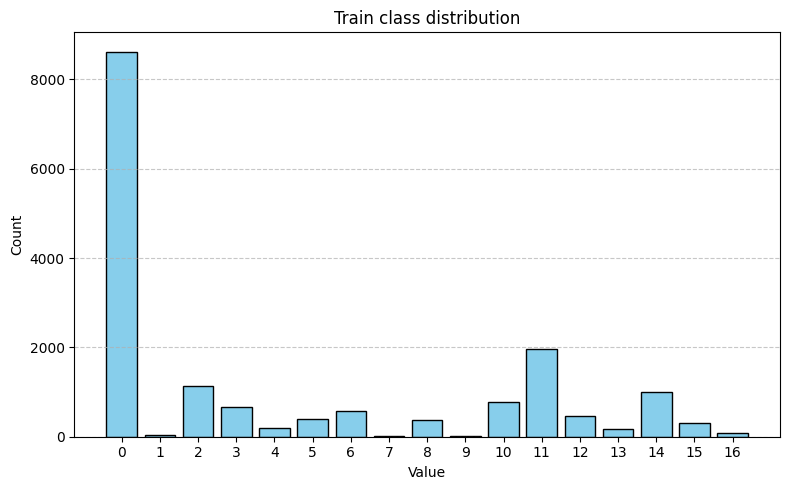

In [7]:

if exampes_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, exampes_per_class
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w), y_masked.reshape(image_h, image_w)
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

plot_numbers_distribution(y_train, desc="Train class distribution")

In [8]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

4. Train model

In [10]:
autoencoder = SpatialAutoEncoder(
    input_channels=image_c, embedding_size=embedding_size
)

In [11]:
autoencoder

SpatialAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(200, 100, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(200, 500, kernel_size=(1, 1), stride=(1, 1))
    (7): Sigmoid()
    (8): Conv2d(500, 17, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Softmax(dim=1)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(17, 500, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(500, 200, kernel_s

In [ ]:
model = AdamOptimizedModule(
    net=autoencoder,
    lr=learning_rate,
    # scheduler_step_size=epochs // 10,
    # scheduler_gamma=0.9,
)
trainer = AutoEncoderTrainer(
    nn.MSELoss(),
    epochs,
    device
)

In [13]:
feedback = trainer.fit(model, train_loader, test_loader)

  0%|          | 0/300 [00:00<?, ?it/s]

5. Train results

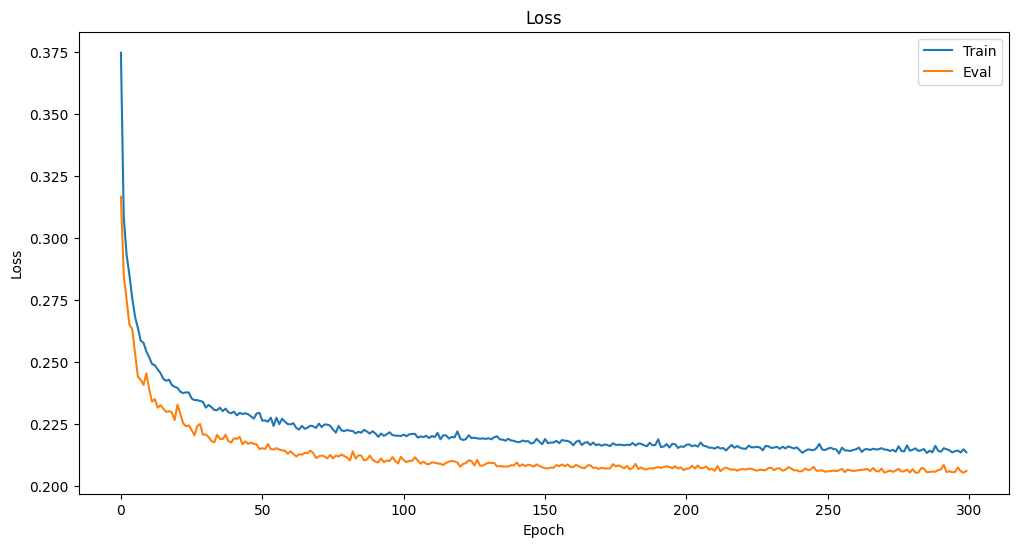

In [14]:
plot_epoch_generic_comparison(
    [it.train["train_loss"] for it in feedback.history],
    [it.eval["eval_loss"] for it in feedback.history],
)